## Read in the data

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
#from fancyimpute import KNN
from sklearn.ensemble import GradientBoostingRegressor
#from xgboost import XGBRegressor

In [6]:
'''
# Read the data, which is spread accross multiple files
real_estate1 = pd.read_excel('immo_by_municipality_1980-1989.xlsx', dtype = {'CD_YEAR': np.int16, 'CD_REFNIS': str})
real_estate2 = pd.read_excel('immo_by_municipality_1990-1999.xlsx', dtype = {'CD_YEAR': np.int16, 'CD_REFNIS': str})
real_estate3 = pd.read_excel('immo_by_municipality_2000-2009.xlsx', dtype = {'CD_YEAR': np.int16, 'CD_REFNIS': str})
real_estate4 = pd.read_excel('immo_by_municipality_2010-2019.xlsx', dtype = {'CD_YEAR': np.int16, 'CD_REFNIS': str})

# Concatenate the data frames
real_estate = pd.concat([real_estate1, real_estate2, real_estate3, real_estate4], axis = 0, copy = False)
del real_estate1, real_estate2, real_estate3, real_estate4
'''

## Exploratory Data Analysis

In [3]:
real_estate = pd.read_csv('real_estate_data_yearly.csv.gz', sep = ";",  dtype = {'CD_REFNIS': str})

In [8]:
real_estate.shape

(509295, 17)

In [9]:
real_estate.head(10)

,CD_YEAR,CD_TYPE_NL,CD_TYPE_FR,CD_REFNIS,CD_REFNIS_NL,CD_REFNIS_FR,CD_PERIOD,CD_CLASS_SURFACE,MS_TOTAL_TRANSACTIONS,MS_TOTAL_PRICE,MS_TOTAL_SURFACE,MS_MEAN_PRICE,MS_P10,MS_P25,MS_P50,MS_P75,MS_P90
0,1980,gewone woonhuizen,maisons d'habitation,11001,AARTSELAAR,AARTSELAAR,Q1,totaal / total,15,938053.0,4671.0,62536.866667,31945.000000,54537.0,62519.0,72936.0,91721.0
1,1980,gewone woonhuizen,maisons d'habitation,11001,AARTSELAAR,AARTSELAAR,Q2,totaal / total,18,1051097.0,4953.0,58394.277778,32226.000000,54537.0,60734.0,61973.0,76847.0
2,1980,gewone woonhuizen,maisons d'habitation,11001,AARTSELAAR,AARTSELAAR,Q3,totaal / total,11,569785.0,4116.0,51798.636364,39043.000000,42142.0,54537.0,63461.0,64452.0
3,1980,gewone woonhuizen,maisons d'habitation,11001,AARTSELAAR,AARTSELAAR,Q4,totaal / total,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1980,gewone woonhuizen,maisons d'habitation,11001,AARTSELAAR,AARTSELAAR,S1,totaal / total,33,1989150.0,9624.0,60277.272727,32226.000000,54537.0,60734.0,69559.0,76847.0
5,1980,gewone woonhuizen,maisons d'habitation,11001,AARTSELAAR,AARTSELAAR,S2,totaal / total,18,939145.0,6969.0,52174.722222,14874.000000,42142.0,55565.5,63461.0,69931.0
6,1980,gewone woonhuizen,maisons d'habitation,11001,AARTSELAAR,AARTSELAAR,Y,totaal / total,51,2928295.0,16593.0,57417.549020,32226.000000,49579.0,59494.0,68419.0,73129.0
7,1980,gewone woonhuizen,maisons d'habitation,11002,ANTWERPEN,ANVERS,Q1,totaal / total,772,24732620.0,167196.0,32037.072539,9916.000000,16361.0,26165.5,42142.0,61973.0
8,1980,gewone woonhuizen,maisons d'habitation,11002,ANTWERPEN,ANVERS,Q2,totaal / total,878,27972998.0,160825.0,31859.906606,9693.692308,15700.0,26029.0,42142.0,61973.0
9,1980,gewone woonhuizen,maisons d'habitation,11002,ANTWERPEN,ANVERS,Q3,totaal / total,537,16950291.0,98896.0,31564.787710,9916.000000,16113.0,24789.0,40902.0,61973.0


In [10]:
#real_estate.CD_PERIOD.unique()

array(['Q1', 'Q2', 'Q3', 'Q4', 'S1', 'S2', 'Y'], dtype=object)

First, we can see that we have quarterly, biannual and yearly statistics. We will only consider the yearly ones in this project<br>
Second, we have some percentile and quantile information, that we do not need, so we can filter out those columns<br>
Third, the column names are not very meaningful, rename them

In [11]:
#real_estate = real_estate[real_estate.CD_PERIOD == 'Y']

real_estate = real_estate[['CD_YEAR', 'CD_TYPE_FR', 'CD_REFNIS', 'CD_REFNIS_FR', 'MS_TOTAL_TRANSACTIONS',
                           'MS_TOTAL_PRICE', 'MS_TOTAL_SURFACE', 'MS_MEAN_PRICE']]

real_estate.rename(columns = {'CD_YEAR': 'Year', 'CD_TYPE_FR': 'Property_Type', 'CD_REFNIS': 'REFNIS',
                              'CD_REFNIS_FR': 'Municipality_Name', 'MS_TOTAL_TRANSACTIONS': 'Total_Transactions',
                              'MS_TOTAL_PRICE': 'Total_Price', 'MS_TOTAL_SURFACE': 'Total_Area',
                              'MS_MEAN_PRICE': 'Mean_Price'}, inplace = True)

Find the number of unique values for each column, to understand what we have to deal with

In [13]:
real_estate.nunique()

Year                     38
Property_Type             4
REFNIS                  589
Municipality_Name       588
Total_Transactions     1112
Total_Price           58673
Total_Area            41125
Mean_Price            59102
dtype: int64

We have 38 years, from 1980 till 2017, so the Year count is as expected<br>
There are 4 property types, namely:

In [14]:
real_estate.Property_Type.unique()

array(["maisons d'habitation", 'villas, bungalows, maisons de campagne',
       'appartements, flats, studios', 'terrains à bâtir'], dtype=object)

In [15]:
real_estate.groupby('Property_Type').agg('count').reset_index()

,Property_Type,Year,REFNIS,Municipality_Name,Total_Transactions,Total_Price,Total_Area,Mean_Price
0,"appartements, flats, studios",16348,16348,16348,16348,9239,0,9239
1,maisons d'habitation,22354,22354,22354,22354,22101,22101,22101
2,terrains à bâtir,20507,20507,20507,20507,18435,18435,18435
3,"villas, bungalows, maisons de campagne",19698,19698,19698,19698,9426,9426,9426


In [16]:
real_estate.groupby('Property_Type').agg('sum').reset_index()

,Property_Type,Year,Total_Transactions,Total_Price,Total_Area,Mean_Price
0,"appartements, flats, studios",32705865.0,1106400,1.415378e+11,0.000000e+00,1.163915e+09
1,maisons d'habitation,44674437.0,2505623,2.497702e+11,1.603081e+09,2.241651e+09
2,terrains à bâtir,40952556.0,971912,4.648803e+10,1.154819e+09,9.911973e+05
3,"villas, bungalows, maisons de campagne",39389378.0,361986,9.549157e+10,5.550089e+08,2.462367e+09


There are comparable number of transactions for all 4 property types, whereas there are 2.3 million house transactions, about a million each apartment and plot transactions and 300 k villa transactions. These seem reasonable differences<br>
However, we have 589 unique REFNIS values (which is to be expected, since there are 589 Belgian municipalities), but only 588 municipality names. Let us find out why

In [17]:
temp = real_estate.drop_duplicates(subset = ['REFNIS', 'Municipality_Name']).groupby('Municipality_Name').size()
temp[temp == 2]

Municipality_Name
SAINT-NICOLAS    2
dtype: int64

In [18]:
real_estate.loc[real_estate.Municipality_Name == 'SAINT-NICOLAS', 'REFNIS'].unique()

array(['46021', '62093'], dtype=object)

A simple search on Google for 'Belgian municipality SAINT-NICOLAS' shows that there are 2 Belgian municipalities with this name, one in the Province of East Flanders and another one in the Province of Liège. Mystery solved<br><br>
Let us check if the amount of data varies over time. This is in theory something we do not expect. While there are definitely more transactions in the recent years, due to population growth, the data consist of consolidated information, whose volume should be constant

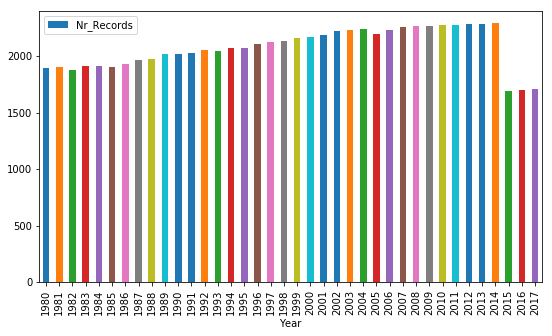

In [19]:
temp = real_estate.groupby('Year').size().reset_index(name = 'Nr_Records')
temp.plot.bar(x = 'Year', y = 'Nr_Records', figsize = (9, 5));

There seems to be an increasing amount of data as time goes by, however, as of 2015, there is a sharp drop

In [20]:
real_estate.loc[real_estate.Year >= 2015, 'Property_Type'].unique()

array(["maisons d'habitation", 'villas, bungalows, maisons de campagne',
       'appartements, flats, studios'], dtype=object)

It seems that statistics about plots are no longer gathered or communicated as of 2015. We could drop this property type for all years, but instead let us only keep the data for 2014 and earlier, when all 4 property types are available

In [21]:
real_estate = real_estate[real_estate.Year <= 2014]

We still need to investigate the reason for having more data as time goes by. If we had data for all years, all property types and all municipalities, we would have

In [22]:
35 * 4 * 589

82460

records, however we only have

In [23]:
real_estate.shape[0]

73801

In [24]:
print(real_estate.Total_Transactions.min(), real_estate.Total_Transactions.max())

1 5699


It looks like 0's are not reported and we are bound to have years when there are no transactions for some property types for the smaller municipalities<br>
We will need to add these 0's because the machine learning algorithm has to be aware of them<br>
Before doing that, let us check for correlation between year and price/area

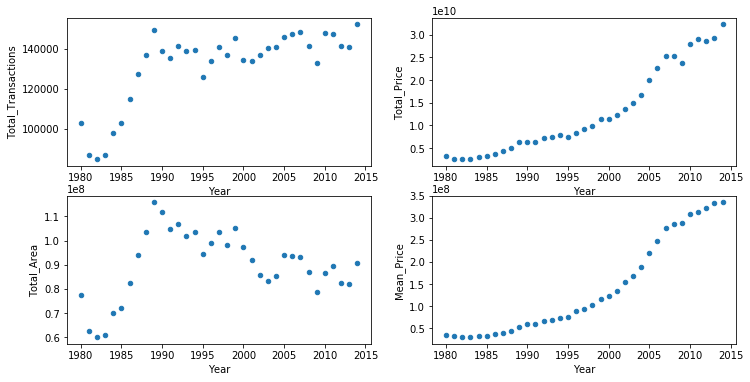

In [25]:
temp = real_estate.groupby('Year').agg('sum').reset_index()
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 6))

for ycol, ax in zip(['Total_Transactions', 'Total_Price', 'Total_Area', 'Mean_Price'], axes.reshape(4, )):
    temp.plot.scatter(x = 'Year', y = ycol, ax = ax)

The number of transactions went down first, then sharply up for a few years and then it fluctuated with only a slight upward tendency<br>
The total area went followed the same pattern initially (i.e. first down and then sharply up), however, there is a clear downward tendency since 1990<br>
The price (both total and mean) went slightly down first and then steadily up, except for a period of a few years around 2005 when it went sharply up<br>
The computed correlations reflect these findings

In [26]:
temp.corr().iloc[0]

Year                  1.000000
Total_Transactions    0.752870
Total_Price           0.952937
Total_Area            0.181720
Mean_Price            0.948791
Name: Year, dtype: float64

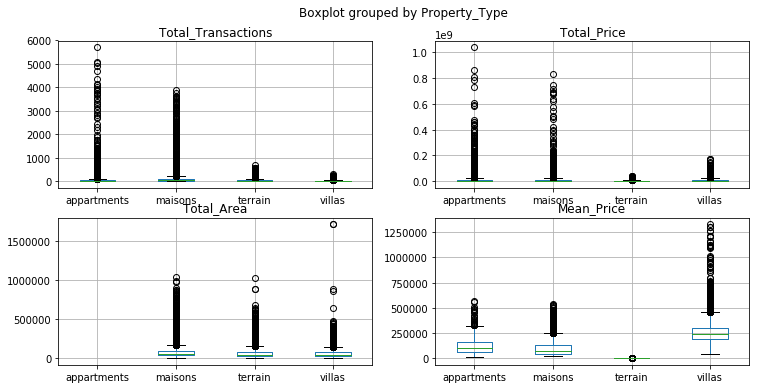

In [27]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 6))

for xcol, ax in zip(['Total_Transactions', 'Total_Price', 'Total_Area', 'Mean_Price'], axes.reshape(4, )):
    real_estate.boxplot(column = xcol, by = 'Property_Type', ax = ax)
    ax.set_xticklabels(['appartments', 'maisons', 'terrain', 'villas'])
    ax.set_xlabel(None)

The number of transactions and total price have way more spread for apartments and houses than for plots and villas, which makes sense, since the high values must come from municipalities which are part of big cities, where there are a lot more apartments and houses than plots and villas<br>
The total area has more or less the same spread across all property types (except for apartments, for which it is not given). However, since there are fewer transactions for plots than there are for houses and even fewer for villas, this means that the average area of villas is higher than that of plots which is higher than that of houses, a perfectly reasonable finding<br>
The average price has the most spread for villas, which is normal, since there are some municipalities with very expensive properties, like those at the North Sea and some Brussels municipalities. For plots, there seems to be very little spread, we will investigate why in the following section

## Missing Data and Data Consistency

In [28]:
real_estate.isnull().sum()

Year                      0
Property_Type             0
REFNIS                    0
Municipality_Name         0
Total_Transactions        0
Total_Price           18705
Total_Area            26932
Mean_Price            18705
dtype: int64

We've got quite a few records with missing price and even more with missing area

In [30]:
real_estate[real_estate.Total_Price.isnull()].head()

,Year,Property_Type,REFNIS,Municipality_Name,Total_Transactions,Total_Price,Total_Area,Mean_Price
1075,1980,maisons d'habitation,24137,GLABBEEK,7,NaN,NaN,NaN
1382,1980,maisons d'habitation,33016,MESSINES,6,NaN,NaN,NaN
2095,1980,maisons d'habitation,45062,HOREBEKE,6,NaN,NaN,NaN
2940,1980,maisons d'habitation,63001,AMBLEVE,7,NaN,NaN,NaN
3056,1980,maisons d'habitation,63067,SAINT-VITH,8,NaN,NaN,NaN


It seems that price and area are not reported when the number of transactions is small

In [31]:
print(real_estate[real_estate.Total_Price.isnull()].Total_Transactions.unique())
print(real_estate[real_estate.Total_Price.isnull()].shape[0])

[7 6 8 9 5 1 2 3 4]
18705


The limit is 10. When there are fewer than 10 transactions, there is no price or area. We will need to impute these values somehow (done in the Data Imputation section)<br>
We already saw in the previous section that the area is never provided for apartments, let us make sure that it is always provided for the other property types, when the price exists

In [32]:
len(real_estate[(real_estate.Property_Type != 'appartements, flats, studios') & (real_estate.Total_Price.notnull())
                      & (real_estate.Total_Area.isnull())])

0

Ok, so the appartments never have an area, while the other property types always have an area, provided there are 10 or more transactions. It probably makes sense to add a feature which specifies this<br>
Let us check now if the mean price is always as expected

In [33]:
real_estate[(real_estate.Mean_Price.notnull())
            & (np.round(real_estate.Mean_Price) != np.round(real_estate.Total_Price / real_estate.Total_Transactions))].head()

,Year,Property_Type,REFNIS,Municipality_Name,Total_Transactions,Total_Price,Total_Area,Mean_Price
7868,1980,terrains à bâtir,11001,AARTSELAAR,91,2034217.0,67912.0,29.953719
7875,1980,terrains à bâtir,11002,ANVERS,339,13125867.0,247050.0,53.130407
7882,1980,terrains à bâtir,11004,BOECHOUT,51,1385191.0,58141.0,23.824685
7896,1980,terrains à bâtir,11007,BORSBEEK,42,926291.0,24985.0,37.073884
7903,1980,terrains à bâtir,11008,BRASSCHAAT,112,3918831.0,149572.0,26.200298


In [34]:
real_estate[(real_estate.Mean_Price.notnull())
            & (np.round(real_estate.Mean_Price) != np.round(real_estate.Total_Price / real_estate.Total_Transactions))].Property_Type.value_counts()

terrains à bâtir    18435
Name: Property_Type, dtype: int64

In [35]:
2034217.0 / 67912.0

29.95371951937802

The mean price for plots is the mean price per square metre, while for the other property types, it is the mean price per property. We will unify the meaning of the columns

In [36]:
real_estate['Mean_Price'] = real_estate.Total_Price / real_estate.Total_Transactions
real_estate['Mean_Area'] = real_estate.Total_Area / real_estate.Total_Transactions

We need now to create the missing records, those for which the number of transactions is 0 and which are not present in the data

In [37]:
# We store the municiality names. Even though they are not really needed for machine learning,
# they make the data much more user-friendly
mun_data = real_estate.drop_duplicates(subset = ['REFNIS', 'Municipality_Name'])[['REFNIS', 'Municipality_Name']]

In [38]:
# Generate all possible values for year, property type and municipality
all_years = real_estate.Year.unique()
all_prop_types = real_estate.Property_Type.unique()
all_muns = real_estate.REFNIS.unique()

In [39]:
# Create the cartesian product
grid = np.array(list(product(*[all_years, all_prop_types, all_muns])))
# Create the full data frame
grid = pd.DataFrame(np.vstack(grid), columns = ['Year', 'Property_Type', 'REFNIS'])
grid.Year = grid.Year.astype(np.int64)
# Merge the data with the full frame
real_estate = grid.merge(real_estate, on = ['Year', 'Property_Type', 'REFNIS'], how = 'left')

In [40]:
# Add the municipality names as a new column
real_estate = real_estate.merge(mun_data, on = 'REFNIS', suffixes = ('', '_y'), copy = False)

In [41]:
# Update the municipality names
real_estate['Municipality_Name'] = real_estate['Municipality_Name_y']
real_estate.drop('Municipality_Name_y', axis = 1, inplace = True)
# Fill the newly added rows with 0's. We cannot mass replace with 0, as there are existing NA's that we need to handle
real_estate.loc[real_estate.Total_Transactions.isnull(), 'Total_Transactions'] = 0
real_estate.Total_Transactions = real_estate.Total_Transactions.astype(np.int64)
real_estate.loc[real_estate.Total_Transactions == 0, 'Total_Price'] = 0
real_estate.loc[real_estate.Total_Transactions == 0, 'Total_Area'] = 0
real_estate.loc[real_estate.Total_Transactions == 0, 'Mean_Price'] = 0
real_estate.loc[real_estate.Total_Transactions == 0, 'Mean_Area'] = 0

## Basic Feature Engineering

In [42]:
# Create a feature to distinguish imputed prices
real_estate['Is_Price_Imputed'] = 0
real_estate.loc[real_estate.Total_Price.isnull(), 'Is_Price_Imputed'] = 1

In [43]:
# The area is always missing for apartments, create a feature for this
real_estate['Is_Area_Missing'] = 0
real_estate.loc[real_estate.Property_Type == 'appartements, flats, studios', 'Is_Area_Missing'] = 1
# Set the total and mean areas to 0 for apartments, in order to eliminate the NA's
real_estate.loc[real_estate.Property_Type == 'appartements, flats, studios', 'Total_Area'] = 0
real_estate.loc[real_estate.Property_Type == 'appartements, flats, studios', 'Mean_Area'] = 0

In [44]:
# Create a feature to distinguish the imputed areas
real_estate['Is_Area_Imputed'] = 0
real_estate.loc[real_estate.Total_Price.isnull() &
                (real_estate.Property_Type != 'appartements, flats, studios'), 'Is_Area_Imputed'] = 1

## Data Imputation

We need to impute the price and area for the records with fewer than 10 transactions. While we could do it based on the current data, there is not much information for the imputation algorithm. It could work based on year/municipality, but it is likely to yield poor results, since it would be unable to find similar municipalities within the same year<br>
We will add the district, province and region for each municipality, since municipalities under the same district, province or region are likely to have similar real estate prices<br>
We will also add population and tax information, since municipalities with similar populations and/or similar income are likely to have similar real estate prices<br>
Let us add population information first

In [46]:
# Create a base data frame with the municipality IDs
pop_data = pd.DataFrame(data = real_estate.REFNIS.unique(), columns = ['REFNIS'])

In [47]:
# Read the population data as a dictionary of data frames
pop_data_temp = pd.read_excel('Population_de_droit_au_1_janvier,_par_commune,_par_sexe_2011_2017.xls', sheet_name = None,
                              skiprows = 1, usecols = 'A, E', dtype = {' code INS': str})

In [48]:
pop_data_temp.keys()

odict_keys(['Population de droit en 2018', 'Population de droit en 2017', 'Population de droit en 2016', 'population de droit en 2015', 'Population de droit en 2014', 'Population de droit en 2013', 'Population de droit en 2012', 'Population de droit en 2011'])

In [49]:
# Convert the data from separate data frames into a single one
for key, value in pop_data_temp.items():
    value.rename(columns = {' code INS': 'REFNIS', 'Total': key[-4:]}, inplace = True)
    pop_data = pop_data.merge(value, on = 'REFNIS', copy = False)

In [50]:
pop_data.head()

,REFNIS,2018,2017,2016,2015,2014,2013,2012,2011
0,11001,14304.0,14222.0,14262.0,14157.0,14207.0,14226.0,14281.0,14311.0
1,11002,523248.0,520504.0,517042.0,513570.0,510610.0,507911.0,502604.0,493517.0
2,11004,13120.0,12908.0,12844.0,12792.0,12804.0,12774.0,12724.0,12728.0
3,11005,17970.0,17788.0,17737.0,17559.0,17231.0,17227.0,17166.0,16989.0
4,11007,10685.0,10581.0,10540.0,10465.0,10451.0,10278.0,10233.0,10207.0


In [51]:
# Transform the data from horizontal to vertical
pop_data = pd.melt(pop_data, id_vars = 'REFNIS', value_vars = ['2018', '2017', '2016', '2015', '2014', '2013', '2012', '2011'],
       var_name = 'Year', value_name = 'Population')
pop_data.Population = pop_data.Population.astype(np.int64)
pop_data.Year = pop_data.Year.astype(np.int64)

In [52]:
pop_data.head()

,REFNIS,Year,Population
0,11001,2018,14304
1,11002,2018,523248
2,11004,2018,13120
3,11005,2018,17970
4,11007,2018,10685


We only have data from 2011 onwards. We need to estimate the values for the previous years. While it is most likely not the best method and the assumptions do not hold, we will use linear regression for simplicity's sake

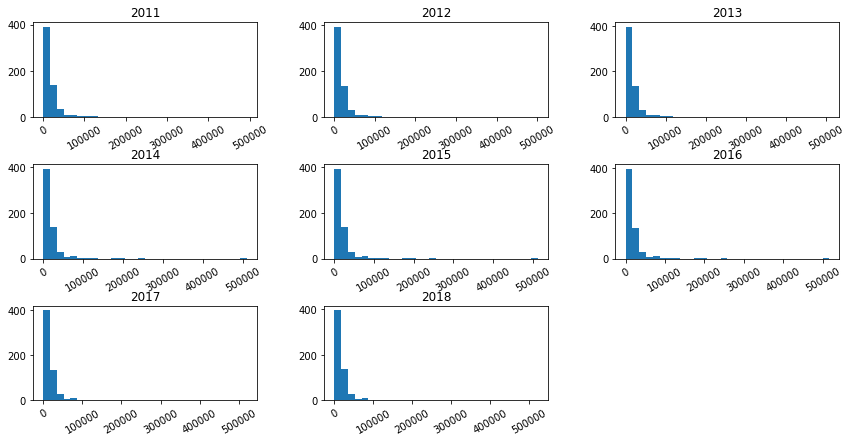

In [53]:
pop_data.hist(column = 'Population', by = 'Year', bins = 30, figsize = (14, 7), xrot = 30);

The data is highly right skewed. We will log transform it to reduce skewness, even though the assumptions of linearity will still not hold

In [54]:
# Create a copy of the initial data, as we will need to dummify it
# Order it first, as this will be needed when getting the predictions
pop_data.sort_values(by = ['Year', 'REFNIS'], ascending = [False, True], inplace = True)
populations = pop_data.copy()

In [55]:
pop_data.Population = np.log(pop_data.Population)

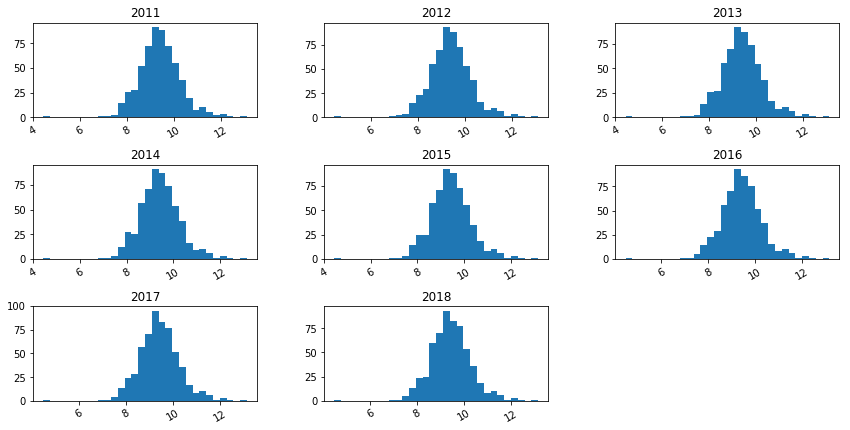

In [56]:
pop_data.hist(column = 'Population', by = 'Year', bins = 30, figsize = (14, 7), xrot = 30);

In [57]:
pop_data = pd.get_dummies(pop_data, columns = ['REFNIS'], prefix = ['Mun'])

We will create a regressor for all municipalities in a go instead of for each one individualy, as we only have data for 8 years and there are municipalities whose population goes up and down during this time, which might create a regressor with negative slope

In [58]:
linreg = linear_model.LinearRegression(normalize = True)
X = pop_data[pop_data.columns[pop_data.columns != 'Population']]
y = pop_data.Population
linreg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In order to make predictions for the years 1980 until 2010, we make a copy of the data for the year 2011, subtract 1, predict and repeat

In [59]:
temp_pop = pop_data.loc[pop_data.Year == 2011, [col for col in pop_data.columns if col != 'Population']].copy()
for i in range(2010 - 1980 + 1):
    temp_pop.Year = temp_pop.Year - 1
    preds = linreg.predict(temp_pop)
    temp_pop1 = pd.DataFrame({'Year': (2010 - i), 'REFNIS': populations.loc[populations.Year == 2018, 'REFNIS'],
                              'Population': np.round(np.exp(preds))})
    populations = pd.concat([populations, temp_pop1], axis = 0, copy = False)
populations.Population = populations.Population.astype(np.int64)

In [60]:
real_estate = real_estate.merge(populations, on = ['Year', 'REFNIS'], copy = False)

Let us add tax information now

In [61]:
tax_struct = pd.read_excel('TF_PSNL_INC_TAX_MUNTY.xlsx',
                           names = ['Year', 'REFNIS', 'Total_Income', 'Number_of_Incomes', 'Number_Of_Residents',
                                    'DSTR_REFNIS', 'PROV_REFNIS', 'RGN_REFNIS'],
                           usecols = 'A, B, F, G, AE, AH, AK, AN',
                           dtype = {'CD_YEAR': np.int, 'MS_NBR_TOT_NET_INC': np.int, 'MS_TOT_RESIDENTS': np.int,
                                    'CD_MUNTY_REFNIS': str, 'CD_DSTR_REFNIS': str, 'CD_PROV_REFNIS': str, 'CD_RGN_REFNIS': str})

In [62]:
# Brussels municipalities dot not have a province, so create an artificial one
tax_struct.loc[tax_struct.PROV_REFNIS == 'nan', 'PROV_REFNIS'] = '100000'

In [63]:
# Create 2 extra columns, the income per taxpayer and the income per resident
tax_struct['Income_Per_Taxpayer'] = tax_struct.Total_Income / tax_struct.Number_of_Incomes
tax_struct['Income_Per_Resident'] = tax_struct.Total_Income / tax_struct.Number_Of_Residents

In [64]:
# Do not use the number or residents to predict, as that is not available for all years
# We do not need to predict it, as it is the population we already predicted
tax_struct.drop(labels = 'Number_Of_Residents', axis = 1, inplace = True)

As for the population data, we do not have the tax information for all years (only from 2005 until 2015), so we need to estimate it. We wil also use linear regression. The steps are very similar to the population data regression

In [65]:
# Create a copy of the initial data, as we will need to dummify it
# Order it first, as this will be needed when getting the predictions
tax_struct.sort_values(by = ['Year', 'REFNIS'], ascending = [False, True], inplace = True)
tax_preds = tax_struct.copy()
#tax_preds = tax_struct[['Year', 'REFNIS', 'Total_Income', 'Number_of_Incomes', 'Income_Per_Taxpayer', 'Income_Per_Resident']]

In [66]:
# Log transform the data
tax_struct.Total_Income = np.log(tax_struct.Total_Income)
tax_struct.Number_of_Incomes = np.log(tax_struct.Number_of_Incomes)
tax_struct.Income_Per_Taxpayer = np.log(tax_struct.Income_Per_Taxpayer)
tax_struct.Income_Per_Resident = np.log(tax_struct.Income_Per_Resident)

In [67]:
tax_struct = pd.get_dummies(tax_struct, columns = ['REFNIS', 'DSTR_REFNIS', 'PROV_REFNIS', 'RGN_REFNIS'],
                            prefix = ['Mun', 'Dstr', 'Prov', 'Reg'])

In [68]:
linreg = linear_model.LinearRegression(normalize = True)
X = tax_struct[tax_struct.columns[~tax_struct.columns.isin(['Total_Income', 'Number_of_Incomes', 'Income_Per_Taxpayer',
                                                            'Income_Per_Resident'])]]
y = tax_struct[tax_struct.columns[tax_struct.columns.isin(['Total_Income', 'Number_of_Incomes', 'Income_Per_Taxpayer',
                                                           'Income_Per_Resident'])]]
linreg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In order to make predictions for the years 1980 until 2004, we make a copy of the data for the year 2005, subtract 1, predict and repeat

In [69]:
temp_tax = tax_struct.loc[tax_struct.Year == 2005, X.columns].copy()

In [70]:
for i in range(2005 - 1980 + 1):
    temp_tax.Year = temp_tax.Year - 1
    preds = linreg.predict(temp_tax)
    temp_tax1 = pd.DataFrame({'Year': (2004 - i), 'REFNIS': tax_preds.loc[tax_preds.Year == 2015, 'REFNIS'],
                              'DSTR_REFNIS': tax_preds.loc[tax_preds.Year == 2015, 'DSTR_REFNIS'],
                              'PROV_REFNIS': tax_preds.loc[tax_preds.Year == 2015, 'PROV_REFNIS'],
                              'RGN_REFNIS': tax_preds.loc[tax_preds.Year == 2015, 'RGN_REFNIS'],
                              'Total_Income': np.exp(preds[:,0]), 'Number_of_Incomes': np.exp(preds[:,1]),
                              'Income_Per_Taxpayer': np.exp(preds[:,2]), 'Income_Per_Resident': np.exp(preds[:,3])})
    tax_preds = pd.concat([tax_preds, temp_tax1], axis = 0, copy = False)

In order to make predictions for the years 2016 and 2017, we make a copy of the data for the year 2015, add 1, predict and repeat

In [71]:
temp_tax = tax_struct.loc[tax_struct.Year == 2015, X.columns].copy()

In [72]:
for i in range(2017 - 2016 + 1):
    temp_tax.Year = temp_tax.Year + 1
    preds = linreg.predict(temp_tax)
    temp_tax1 = pd.DataFrame({'Year': (2016 + i), 'REFNIS': tax_preds.loc[tax_preds.Year == 2015, 'REFNIS'],
                              'DSTR_REFNIS': tax_preds.loc[tax_preds.Year == 2015, 'DSTR_REFNIS'],
                              'PROV_REFNIS': tax_preds.loc[tax_preds.Year == 2015, 'PROV_REFNIS'],
                              'RGN_REFNIS': tax_preds.loc[tax_preds.Year == 2015, 'RGN_REFNIS'],
                              'Total_Income': np.exp(preds[:,0]), 'Number_of_Incomes': np.round(np.exp(preds[:,1])),
                              'Income_Per_Taxpayer': np.exp(preds[:,2]), 'Income_Per_Resident': np.exp(preds[:,3])})
    tax_preds = pd.concat([tax_preds, temp_tax1], axis = 0, copy = False)
tax_preds.Number_of_Incomes = tax_preds.Number_of_Incomes.astype(np.int64)

In [73]:
# Merge the tax information in the original data frame
real_estate = real_estate.merge(tax_preds, on = ['Year', 'REFNIS'], copy = False)

In [74]:
# Reorder the columns
cols = list(real_estate.columns)
#real_estate = real_estate[cols[:2] + [cols[3]] + [cols[2]] + cols[13:16] + cols[4:13] + cols[16:]]
real_estate = real_estate[cols[:2] + [cols[3]] + [cols[2]] + [cols[13]] + cols[17:19] + cols[4:13] + cols[14:17] + cols[19:]]

In [75]:
real_estate.columns

Index(['Year', 'Property_Type', 'Municipality_Name', 'REFNIS', 'DSTR_REFNIS',
       'PROV_REFNIS', 'RGN_REFNIS', 'Total_Transactions', 'Total_Price',
       'Total_Area', 'Mean_Price', 'Mean_Area', 'Is_Price_Imputed',
       'Is_Area_Missing', 'Is_Area_Imputed', 'Population',
       'Income_Per_Resident', 'Income_Per_Taxpayer', 'Number_of_Incomes',
       'Total_Income'],
      dtype='object')

Ok, so now that we have quite a bit of information for each municipality, we can impute the missing price and area for the records with fewer than 10 transactions. We will do it per property type, first because it does not make sense to do it for heterogeneous data, and second because we cannot easily and meaningfully define a distance between property types. We will use KNN for defining the distance between records. Also, we will not include the records with no transactions in the imputation algorithm

In [76]:
# Order the data first, in order to have the records with the same proprty type grouped together
real_estate.sort_values(by = ['Property_Type', 'REFNIS', 'Year'], inplace = True)

In [77]:
# Create a copy of the initial data, as we will need to dummify it
temp_real_estate = real_estate[real_estate.Total_Transactions > 0].copy()

In [78]:
temp_real_estate = pd.get_dummies(temp_real_estate, columns = ['REFNIS', 'DSTR_REFNIS', 'PROV_REFNIS', 'RGN_REFNIS'],
                                  prefix = ['Mun', 'Dstr', 'Prov', 'Reg'])

In [111]:
# Create an empty array for holding the imputed price and area
# We only impute the mean values and compute the total values based on the number of transactions
imputed_values = np.empty((temp_real_estate.shape[0], 2))
last_index = 0
# We min max scale the columns, in order for all of them to have the same weight
# We do not scale the dummified columns, neither the ones which are not used in the prediction
cols_to_scale = list(set(temp_real_estate.columns) -
                     set([col for col in temp_real_estate.columns if col.startswith(('Mun', 'Dstr', 'Prov', 'Reg'))]) -
                     set(['Property_Type', 'Is_Price_Imputed', 'Is_Area_Imputed', 'Is_Area_Missing', 'Total_Price',
                          'Total_Area', 'Mean_Price', 'Mean_Area']))
for prop_type in temp_real_estate.Property_Type.unique():
    # Select only the numeric columns
    temp_prop = temp_real_estate[temp_real_estate.Property_Type == prop_type].select_dtypes(include = ['number'])
    # Filter out the columns which will not be predicted or are not relevant for predicting
    temp_prop = temp_prop[[col for col in temp_prop.columns if col not in ['Total_Price', 'Total_Area', 'Is_Price_Imputed',
                                                                           'Is_Area_Missing', 'Is_Area_Imputed']]]
    # Scale the data
    scaler = MinMaxScaler()
    temp_prop[cols_to_scale] = scaler.fit_transform(temp_prop[cols_to_scale])
    # Impute the missing information
    temp_prop = KNN(3).fit_transform(temp_prop)
    #temp_prop = IterativeImputer().fit_transform(temp_prop)
    # Save the mean price and area in the main array
    imputed_values[last_index:(last_index + temp_prop.shape[0]), :] = temp_prop[:, [2, 3]]
    last_index += temp_prop.shape[0]
real_estate.loc[real_estate.Total_Transactions > 0, ['Mean_Price', 'Mean_Area']] = imputed_values
# Compute the total values
real_estate.Total_Price = real_estate.Mean_Price * real_estate.Total_Transactions
real_estate.Total_Area = real_estate.Mean_Area * real_estate.Total_Transactions

D:\Games\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Imputing row 1/16348 with 0 missing, elapsed time: 981.242
Imputing row 101/16348 with 0 missing, elapsed time: 981.242
Imputing row 201/16348 with 0 missing, elapsed time: 981.242
Imputing row 301/16348 with 0 missing, elapsed time: 981.258
Imputing row 401/16348 with 0 missing, elapsed time: 981.258
Imputing row 501/16348 with 0 missing, elapsed time: 981.258
Imputing row 601/16348 with 0 missing, elapsed time: 981.258
Imputing row 701/16348 with 0 missing, elapsed time: 981.258
Imputing row 801/16348 with 0 missing, elapsed time: 981.273
Imputing row 901/16348 with 0 missing, elapsed time: 981.273
Imputing row 1001/16348 with 1 missing, elapsed time: 981.273
Imputing row 1101/16348 with 0 missing, elapsed time: 981.273
Imputing row 1201/16348 with 0 missing, elapsed time: 981.289
Imputing row 1301/16348 with 0 missing, elapsed time: 981.289
Imputing row 1401/16348 with 1 missing, elapsed time: 981.289
Imputing row 1501/16348 with 0 missing, elapsed time: 981.305
Imputing row 1601/16

Imputing row 14401/16348 with 0 missing, elapsed time: 982.261
Imputing row 14501/16348 with 1 missing, elapsed time: 982.261
Imputing row 14601/16348 with 0 missing, elapsed time: 982.276
Imputing row 14701/16348 with 0 missing, elapsed time: 982.276
Imputing row 14801/16348 with 1 missing, elapsed time: 982.276
Imputing row 14901/16348 with 0 missing, elapsed time: 982.292
Imputing row 15001/16348 with 0 missing, elapsed time: 982.292
Imputing row 15101/16348 with 0 missing, elapsed time: 982.308
Imputing row 15201/16348 with 1 missing, elapsed time: 982.323
Imputing row 15301/16348 with 1 missing, elapsed time: 982.339
Imputing row 15401/16348 with 1 missing, elapsed time: 982.354
Imputing row 15501/16348 with 1 missing, elapsed time: 982.354
Imputing row 15601/16348 with 0 missing, elapsed time: 982.370
Imputing row 15701/16348 with 1 missing, elapsed time: 982.386
Imputing row 15801/16348 with 1 missing, elapsed time: 982.401
Imputing row 15901/16348 with 1 missing, elapsed time: 

D:\Games\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


KeyboardInterrupt: 

In [79]:
# Drop the columns used for imputation only
real_estate.drop(['Population', 'Total_Income', 'Number_of_Incomes', 'Income_Per_Taxpayer', 'Income_Per_Resident'],
                 axis = 1, inplace = True)

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
#from fancyimpute import KNN
from sklearn.ensemble import GradientBoostingRegressor
#from xgboost import XGBRegressor
real_estate = pd.read_csv('temp.csv',  dtype = {'Year': np.int16, 'REFNIS': str, 'DSTR_REFNIS': str, 'PROV_REFNIS': str, 'RGN_REFNIS': str,
                                               'Is_Price_Imputed': np.int8, 'Is_Area_Missing': np.int8, 'Is_Area_Imputed': np.int8})

## Advanced Feature Engineering

Since we have a sort of a time series, we cannot use features from the same record to predict, as these will not be available at the time of the prediction. We need to use features from the previous records and we need to generate these features<br>
We have the transactions, price and area that we can use, but let us generate more<br>
We can group by:<br>
1. single grouping: property type, municipality, district, province, region
2. double grouping: property type and district, property type and province, property type and region

In [39]:
# Single grouping
# Generate total and mean number of transactions, total price, total area
# Do not generate the mean price and area, as these will be non-weighted
for type_id in ['Property_Type', 'REFNIS', 'DSTR_REFNIS', 'PROV_REFNIS', 'RGN_REFNIS']:
    for column_id, aggregator, aggtype in [('Total_Transactions', np.sum, 'sum'), ('Total_Transactions', np.mean, 'avg'),
                                           ('Total_Price', np.sum, 'sum'), ('Total_Area', np.sum, 'sum')]:
        mean_df = real_estate[['Year', type_id, column_id]].groupby(['Year', type_id]).aggregate(aggregator).reset_index()
        mean_df.columns = ['Year', type_id, type_id + '_' + aggtype + '_' + column_id]
        real_estate = real_estate.merge(mean_df, on = ['Year', type_id], how = 'left')

In [40]:
# Generate the weighted mean price and area
# We might have no transactions for some groups, which will generate NaN values. Fill them with 0
for type_id in ['Property_Type', 'REFNIS', 'DSTR_REFNIS', 'PROV_REFNIS', 'RGN_REFNIS']:
    for column_id in ['Total_Price', 'Total_Area']:
        total_col = type_id + '_sum_' + column_id
        trans_col = type_id + '_sum_Total_Transactions'
        avg_col = type_id + '_avg_' + column_id
        real_estate[avg_col] = real_estate[total_col] / real_estate[trans_col]
        real_estate.loc[real_estate[trans_col] == 0, avg_col] = 0

In [41]:
# Double grouping
# Generate total and mean number of transactions, total price, total area
# Do not generate the mean price and area, as these will be non-weighted
for type_id in [['Property_Type', 'DSTR_REFNIS'], ['Property_Type', 'PROV_REFNIS'], ['Property_Type', 'RGN_REFNIS']]:
    for column_id, aggregator, aggtype in [('Total_Transactions', np.sum, 'sum'), ('Total_Transactions', np.mean, 'avg'),
                                           ('Total_Price', np.sum, 'sum'), ('Total_Area', np.sum, 'sum')]:
        mean_df = real_estate[['Year'] + type_id + [column_id]].groupby(['Year'] + type_id).aggregate(aggregator).reset_index()
        mean_df.columns = ['Year'] + type_id + ['_'.join(type_id) + '_' + aggtype + '_' + column_id]
        real_estate = real_estate.merge(mean_df, on = ['Year'] + type_id, how = 'left')

In [42]:
# Generate the weighted mean price and area
# We might have no transactions for some groups, which will generate NaN values. Fill them with 0
for type_id in [['Property_Type', 'DSTR_REFNIS'], ['Property_Type', 'PROV_REFNIS'], ['Property_Type', 'RGN_REFNIS']]:
    for column_id in ['Total_Price', 'Total_Area']:
        total_col = '_'.join(type_id) + '_sum_' + column_id
        trans_col = '_'.join(type_id) + '_sum_Total_Transactions'
        avg_col = '_'.join(type_id) + '_avg_' + column_id
        real_estate[avg_col] = real_estate[total_col] / real_estate[trans_col]
        real_estate.loc[real_estate[trans_col] == 0, avg_col] = 0

We have normal and aggregate values, we can generate lagged features (values for the same municipality and property type x years before, for example the number of transactions 1 year before). On top of that, we can generate lagged values for Is_Price_Imputed and Is_Area_Imputed, in order to inform the algorithm to rely less on such records

In [43]:
# Define the list of columns for which to create lags
cols_for_lag = list(set(real_estate.columns) -
                    set(['Year', 'Property_Type', 'REFNIS', 'DSTR_REFNIS', 'PROV_REFNIS', 'RGN_REFNIS', 'Municipality_Name',
                         'Is_Area_Missing', 'Population', 'Total_Income', 'Number_of_Incomes', 'Income_Per_Taxpayer',
                         'Income_Per_Resident']))

In [44]:
# Generate lagged features for a lag of 1, 2, 3, 5 and 10 years
#lags = [0, 1, 2, 3, 5, 10]
lags = [0, 1, 2, 3]

real_estate_new_df = real_estate[['Year', 'Property_Type', 'REFNIS'] + cols_for_lag].copy()

for index in range(1, len(lags)):
    col_names = [col + '_lag_' + str(lags[index]) for col in cols_for_lag]
    real_estate_new_df['Year'] += (lags[index] - lags[index - 1])
    real_estate_new_df.columns = ['Year', 'Property_Type', 'REFNIS'] + col_names
    real_estate = real_estate.merge(real_estate_new_df, on = ['Year', 'Property_Type', 'REFNIS'], how = 'left')

We can also generate rolling features (aggregate values for the same municipality and property type for the previous x years, for example the total number of transactions for the previous 2 years)

In [45]:
# Define the list of columns for which to create rolls
# Only the sums make sense, creating aggregate features for means is a little far fetched
cols_for_rol = ['Total_Transactions', 'Total_Price', 'Total_Area'] + \
                [col for col in real_estate.columns if '_sum_' in col and '_lag_' not in col]
# For transactions, we can compute the sum and and mean
# For price and area, we can compute the sum, as the mean would be non-weighted
aggregations_trans = {'sum': np.sum, 'avg': np.mean}
aggregations_price_area = {'sum': np.sum}

In [46]:
real_estate_new_df = real_estate[['Property_Type', 'REFNIS'] + cols_for_rol].copy()
grouped_sales = real_estate.groupby(['Property_Type', 'REFNIS'], sort = False)
# We need to shift by 1, as the rolling function includes the current row
grouped_shifted_sales = grouped_sales[cols_for_rol].shift(1)

In [47]:
# Generate rolled features for a roll of 2, 3, 4, 5 and 10 years
#rolls = [2, 3, 4, 5, 10]
rolls = [2, 3, 4]

for index in range(len(rolls)):
    rolled_sales = grouped_shifted_sales.rolling(window = rolls[index])
    agg_rolled_sales = rolled_sales.aggregate(list(aggregations_trans.values())).rename(columns = {'mean': 'avg'})
    for col in cols_for_rol:
        if '_Transactions' in col:
            for key, value in aggregations_trans.items():
                real_estate[col + '_' + key + '_rol_' + str(rolls[index])] = agg_rolled_sales[col][key]
        else:
            for key, value in aggregations_price_area.items():
                real_estate[col + '_' + key + '_rol_' + str(rolls[index])] = agg_rolled_sales[col][key]

In [49]:
# Generate the weighted mean price and area rolls
# We might have no transactions for some rolls, which will generate NaN values when dividing. Fill them with 0
for col in [col for col in cols_for_rol if '_Transactions' not in col]:
    for index in range(len(rolls)):
        total_col = col + '_sum_rol_' + str(rolls[index])
        trans_col = col[:col.find('_', -6)] + '_Transactions_sum_rol_' + str(rolls[index])
        avg_col = col + '_avg_rol_' + str(rolls[index])
        real_estate[avg_col] = real_estate[total_col] / real_estate[trans_col]
        real_estate.loc[real_estate[trans_col] == 0, avg_col] = 0

Some records will contain NA values, since the lags and rolls cannot be computed for the oldest years. We need to drop these records, as they cannot be used for machine learning

In [50]:
real_estate = real_estate[real_estate.Year >= (1980 + np.max(rolls))]

In [55]:
a = real_estate.isnull().sum()
a[a > 0]

Series([], dtype: int64)

In [52]:
# Downcast the columns which are sums of transactions
for col in real_estate.columns:
    if 'Transactions' in col and 'avg' not in col:
        real_estate[col] = real_estate[col].astype(np.int64)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [17]:
real_estate.head()

,Year,Property_Type,Municipality_Name,REFNIS,DSTR_REFNIS,PROV_REFNIS,RGN_REFNIS,Total_Transactions,Total_Price,Total_Area,...,Property_Type_PROV_REFNIS_sum_Total_Price_avg_rol_4,Property_Type_PROV_REFNIS_sum_Total_Area_avg_rol_2,Property_Type_PROV_REFNIS_sum_Total_Area_avg_rol_3,Property_Type_PROV_REFNIS_sum_Total_Area_avg_rol_4,Property_Type_RGN_REFNIS_sum_Total_Price_avg_rol_2,Property_Type_RGN_REFNIS_sum_Total_Price_avg_rol_3,Property_Type_RGN_REFNIS_sum_Total_Price_avg_rol_4,Property_Type_RGN_REFNIS_sum_Total_Area_avg_rol_2,Property_Type_RGN_REFNIS_sum_Total_Area_avg_rol_3,Property_Type_RGN_REFNIS_sum_Total_Area_avg_rol_4
4,1984.0,"appartements, flats, studios",AARTSELAAR,11001,11000,10000,2000,36.0,1219049.0,0.0,...,33067.039818,0.0,0.0,0.0,36306.578862,36564.670771,37129.335156,0.0,0.0,0.0
5,1985.0,"appartements, flats, studios",AARTSELAAR,11001,11000,10000,2000,20.0,743995.0,0.0,...,32625.081479,0.0,0.0,0.0,37185.715284,36904.199094,36956.822397,0.0,0.0,0.0
6,1986.0,"appartements, flats, studios",AARTSELAAR,11001,11000,10000,2000,56.0,2223560.0,0.0,...,33378.617857,0.0,0.0,0.0,38220.794135,37603.266085,37297.311888,0.0,0.0,0.0
7,1987.0,"appartements, flats, studios",AARTSELAAR,11001,11000,10000,2000,52.0,2302703.0,0.0,...,34369.976935,0.0,0.0,0.0,39978.221058,39410.688131,38714.726075,0.0,0.0,0.0
8,1988.0,"appartements, flats, studios",AARTSELAAR,11001,11000,10000,2000,60.0,2888962.0,0.0,...,35991.387814,0.0,0.0,0.0,43273.937257,41880.429071,41074.846912,0.0,0.0,0.0


## Machine Learning

There are a number of good algorithms we could use. For this project, we settle for XGBoost (Gradient Bossted Trees), as it provides a very good performance without much tweaking and its usage is quite straightforward<br>
We predict the value of the total price, as this can be used for an estimate of the property tax, for instance<br>
We hold out 2014's data for making predictions

In [56]:
#We cannot use most of the features for the same year, as such values are not available for making predictions
features_to_exclude = [col for col in real_estate.columns if 'lag' not in col and 'rol' not in col
                       and col not in ['Year', 'Property_Type', 'REFNIS', 'DSTR_REFNIS', 'PROV_REFNIS', 'RGN_REFNIS',
                                       'Is_Area_Missing']]

In [57]:
# We need to dummify the non-numeric columns, as XGBoost only works with numeric features
X = real_estate.loc[real_estate.Year < 2014, [col for col in real_estate.columns if col not in features_to_exclude]]
X = pd.get_dummies(X, columns = ['Property_Type', 'REFNIS', 'DSTR_REFNIS', 'PROV_REFNIS', 'RGN_REFNIS'],
                            prefix = ['Prop', 'Mun', 'Dstr', 'Prov', 'Reg'])
y = real_estate.Total_Price[real_estate.Year < 2014]

In [59]:
gbr = GradientBoostingRegressor(random_state = 0)
gbr.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=0,
             subsample=1.0, verbose=0, warm_start=False)

In [146]:
real_estate = real_estate[real_estate.columns[:20]]

In [161]:
real_estate.Year.unique()

array([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014])

In [114]:
aa =real_estate.groupby('Property_Type').agg({'Total_Transactions': np.sum, 'Total_Price': np.sum}).reset_index()

In [115]:
aa['Mean_Price'] = aa.Total_Price / aa.Total_Transactions

In [116]:
aa

,Property_Type,Total_Transactions,Total_Price,Mean_Price
0,"appartements, flats, studios",991348.0,1.163399e+11,117355.215775
1,maisons d'habitation,2325603.0,2.115683e+11,90973.536113
2,terrains à bâtir,971912.0,4.648803e+10,47831.520397
3,"villas, bungalows, maisons de campagne",308397.0,7.720146e+10,250331.431654


In [174]:
real_estate.shape

(82460, 20)

In [139]:
#usecols = 'B, AH, AK, AN'
#parse_cols
# Read the tax data, but only extract the district, province and region for now
tax_struct = pd.read_excel('TF_PSNL_INC_TAX_MUNTY.xlsx', usecols = 'B, AH, AK, AN',
                           dtype = {'CD_MUNTY_REFNIS': str, 'CD_DSTR_REFNIS': str, 'CD_PROV_REFNIS': str,'CD_RGN_REFNIS': str})

In [140]:
# Rename the columns to align with the current data
tax_struct.rename(columns = {'CD_MUNTY_REFNIS': 'REFNIS', 'CD_DSTR_REFNIS': 'DSTR_REFNIS', 'CD_PROV_REFNIS': 'PROV_REFNIS', 'CD_RGN_REFNIS': 'RGN_REFNIS'}, inplace = True)

In [141]:
tax_struct.PROV_REFNIS.unique()

array(['10000', 'nan', '20001', '20002', '30000', '40000', '50000',
       '60000', '70000', '80000', '90000'], dtype=object)

In [142]:
tax_struct.loc[tax_struct.PROV_REFNIS == 'nan', 'PROV_REFNIS'] = '100000'

In [143]:
tax_struct = tax_struct.groupby(['REFNIS', 'DSTR_REFNIS', 'PROV_REFNIS', 'RGN_REFNIS']).agg('count').reset_index()

In [144]:
real_estate = real_estate.merge(tax_struct, on = 'REFNIS', copy = False)

In [145]:
real_estate.head()

,Year,Property_Type,REFNIS,Is_Price_Imputed,Is_Area_Missing,Is_Area_Imputed,DSTR_REFNIS_y,PROV_REFNIS_y,RGN_REFNIS_y,DSTR_REFNIS_x,...,RGN_REFNIS_x,Municipality_Name,Total_Transactions,Total_Price,Total_Area,Mean_Price,Mean_Area,DSTR_REFNIS,PROV_REFNIS,RGN_REFNIS
0,1980,maisons d'habitation,11001,0,0,0,11000,10000,02000,11000,...,02000,AARTSELAAR,51,2928295.0,16593.0,57417.549020,325.352941,11000,10000,02000
1,1980,"villas, bungalows, maisons de campagne",11001,1,0,1,11000,10000,02000,11000,...,02000,AARTSELAAR,8,NaN,NaN,NaN,NaN,11000,10000,02000
2,1980,"appartements, flats, studios",11001,0,1,0,11000,10000,02000,11000,...,02000,AARTSELAAR,22,901144.0,0.0,40961.090909,0.000000,11000,10000,02000
3,1980,terrains à bâtir,11001,0,0,0,11000,10000,02000,11000,...,02000,AARTSELAAR,91,2034217.0,67912.0,22354.032967,746.285714,11000,10000,02000
4,1981,maisons d'habitation,11001,0,0,0,11000,10000,02000,11000,...,02000,AARTSELAAR,58,2796698.0,18505.0,48218.931034,319.051724,11000,10000,02000


In [146]:
real_estate = real_estate[list(real_estate.columns[:3]) + list(real_estate.columns[12:]) + list(real_estate.columns[3:12])]

In [39]:
pop_data = pop_data.merge(tax_struct, on = 'REFNIS', copy = False)

NameError: name 'pop_data' is not defined

In [148]:
pop_data.head()

,REFNIS,DSTR_REFNIS,PROV_REFNIS,RGN_REFNIS
0,11001,11000,10000,02000
1,11002,11000,10000,02000
2,11004,11000,10000,02000
3,11005,11000,10000,02000
4,11007,11000,10000,02000
